# Save Your Optimization Project From Overestimation Bias

  * John Mount, Win Vector LLC
  * Nina Zumel, Win Vector LLC
  * August, 3 2025


## Introduction

Revenue optimization projects can be particularly valuable and exciting. They involve:

  * Estimating demand as a function of offered features, price, and match to market.
  * Picking a set of offerings and prices optimizing the above inferred demand.

The great opportunity of these projects is that one can derive value from improving the inference of the demand estimate function, improving the optimization, and even improving the synergy between these two steps.

However, there is a common situation that can lose client trust and sink revenue optimization projects. Here is an example.

  * You use statistics and machine learning to infer a good estimate of what drives customer net revenue. You then use this inferred objective function in an optimizer to pick an optimal pricing and offering plan. For example, your system reports an expected average per-customer net revenue of `$110.05` for this new plan.
  * You then take the plan to market and the average customer net revenue is seen to be `$34.99`. You overestimated the customer value by `215%`. It is hard to convince a client that an estimate that missed by `215%` was in fact capable of correctly driving all the small steps taken in finding an optimal plan.


The above is quite common for applied optimization projects, and is often unnoticed or at least un-fixed.

However, it *can* be the case that the plan is in fact good, and what went wrong was merely the final estimate of the plan's expected value. To illustrate this we work a simple synthetic example (where the correct answer is known, and we can show that we do in fact get near it).

This lets us show how this problem arises and how to mitigate and fix the problem.



## The issue

It is common practice in optimization problems to use the same objective function to perform the optimization steps and to determine the value of the final plan. This is perfectly correct when we know the exact function we wish to optimize. It turns out this is subtly incorrect when, as is always the case in the real world, we have to estimate or infer the objective function.

Let's take a look at this on a small example.

## Our example

We set up our example as follows. This feels like a *lot* of points, but the real world is at *least* this complicated.

  * A given plan (choice of pricing, offerings and inventory levels) is represented by a variable $x$.
  * We assume a function structure $f_{v}()$ where for a given $v$:  $f_{v}(x)$ is our estimate of the value of the plan $x$.
  * Using AI, market research, past data, machine learning, and statistics we develop an estimate of the scenario parameters: $\tilde{v}$.
  * We use an optimizer to pick $\tilde{x}$ that is the value of $x$ that maximizes $f_{\tilde{v}}(x)$.
  * We pick a function $\hat{f}()$ as our "estimate the expected value of our new plan" function. An obvious (but naive) choice (that we do *not* recommend) is to take $\hat{f}(x) = f_{\tilde{v}}(x)$.
  * We suggest the client take the plan $\tilde{x}$ to market and expect a net revenue not much worse than $\hat{f}(\tilde{x})$.

The above is good procedure that operations researchers, data scientists, and statisticians have used again and again to great success.

The subtle flaw is the *seemingly natural* step of defining the goal evaluation function as $\hat{f}(x) = f_{\tilde{v}}(x)$ or even the seemingly safely buffered $\hat{f}(x) = 0.8 * f_{\tilde{v}}(x)$. These choices routinely leads to the following disaster.

  * The client takes the plan $\tilde{x}$ to market.
  * The observed net revenue is way below $\hat{f}(\tilde{x})$.
  * As the above is one of the *few* things that can be checked, this failure seems to discredit the methodology used, the scenario estimate $\tilde{v}$, and the market plan $\tilde{x}$.

There *is* a fix, but before we get into the fix let's see an example of the failure.

## The failure

In [1]:
# import modules and functions
# hide all input cells with:
# jupyter nbconvert --no-input  --to html opt_example.ipynb
import inspect
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
import plotnine
from plotnine import *
from opt_example_fns import *

# simple default rng for repeatability and to try and advertise we are not venue shopping
rng = np.random.default_rng(2025)
# set plot size
plotnine.options.figure_size = (16, 8)

Below is our artificial example function to maximize. `x` is the parameters we are trying to maximize. `v` specifies what objective we are trying to maximize.


In [2]:
# define and display our function.
# to drop all input cells, transform sheet with: jupyter nbconvert --no-input  --to html opt_example.ipynb
def f(x: np.ndarray, *, v: np.ndarray) -> float:
    """
    Our objective function.
      x is the plan we are trying to value.
      v is the scenario parameters determining the valuation.
    Return: estimated net revenue value.
    """
    return (
        np.dot(v, x)           # gross revenue
        - 0.1 * np.dot(x, x)   # models risk factor and/or decreasing returns on x
        - 200                  # fixed costs
    )

display(Markdown(f"```python\n{inspect.getsource(f)}\n```"))

```python
def f(x: np.ndarray, *, v: np.ndarray) -> float:
    """
    Our objective function.
      x is the plan we are trying to value.
      v is the scenario parameters determining the valuation.
    Return: estimated net revenue value.
    """
    return (
        np.dot(v, x)           # gross revenue
        - 0.1 * np.dot(x, x)   # models risk factor and/or decreasing returns on x
        - 200                  # fixed costs
    )

```

We simulate our unknown true objective $v_{true}$ and our estimated approximation of this objective: $\tilde{v}$. With synthetic data we can know the true answer and use it to check our inferences.


In [3]:
v_approx = estimate_v(rng)

### The common (naive) plan

We now simulate a simple optimizer that is stepping a proposed plan `x` along the ray from the origin through $\tilde{v}$ (or `v_approx`) to optimize `f()`. For this simple objective we can inspect for the optimal `x` in one smart step, but we want to simulate a more typical optimizer that is taking small steps.


In [4]:
d = pd.DataFrame({"step number": range(101)})
d["x"] = [v_approx * s for s in np.linspace(0, 7.5, endpoint=True, num=d.shape[0])]
d["self evaluation (common method)"] = [f(x=x, v=v_approx) for x in d["x"]]

In [5]:
d_max = d.loc[[d["self evaluation (common method)"].idxmax()], :]

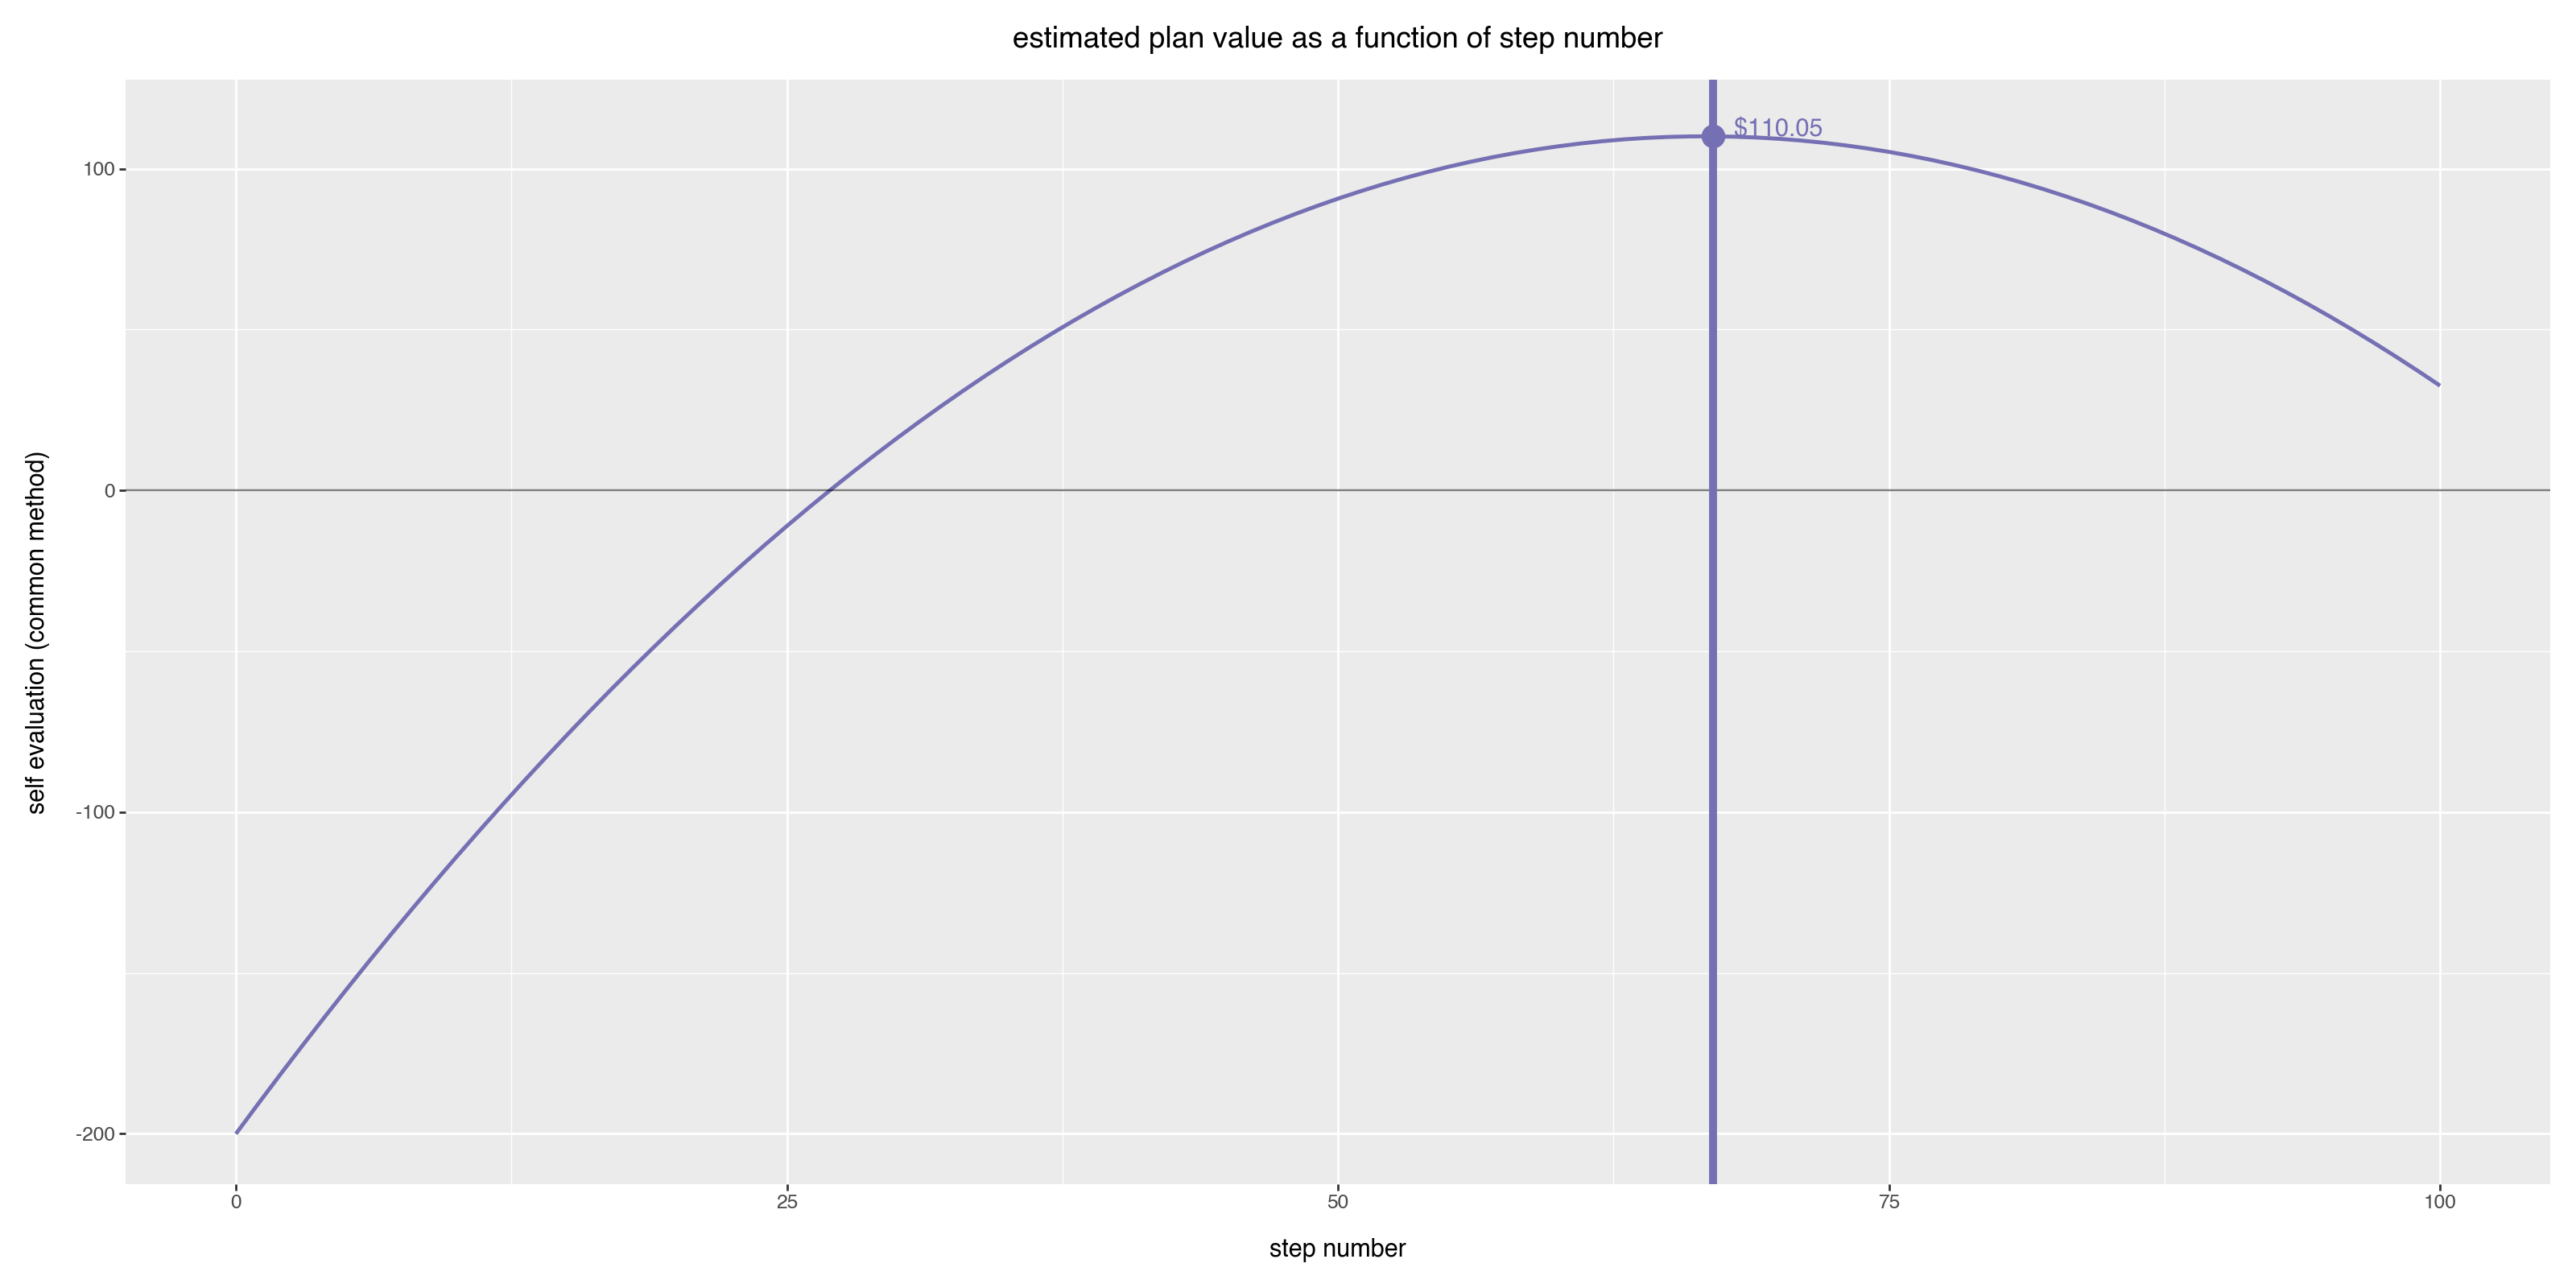

In [6]:
plot_1(d, d_max=d_max, title="estimated plan value as a function of step number")

The table below shows us the simulated stepping optimizer ran for `67` steps and reported (or claimed) an optimal value of `$110.05`.

In [7]:
d_max.round(2)

,step number,x,self evaluation (common method)
67,67,"[1.0554776264750827, -8.733526853898018, 7.622...",110.05


### The fly in the ointment

Now let's see how well this set of proposed plans behaves against the actual objective function.


In [8]:
d["ideal evaluation (not implementable)"] = [f(x, v=v_true) for x in d["x"]]

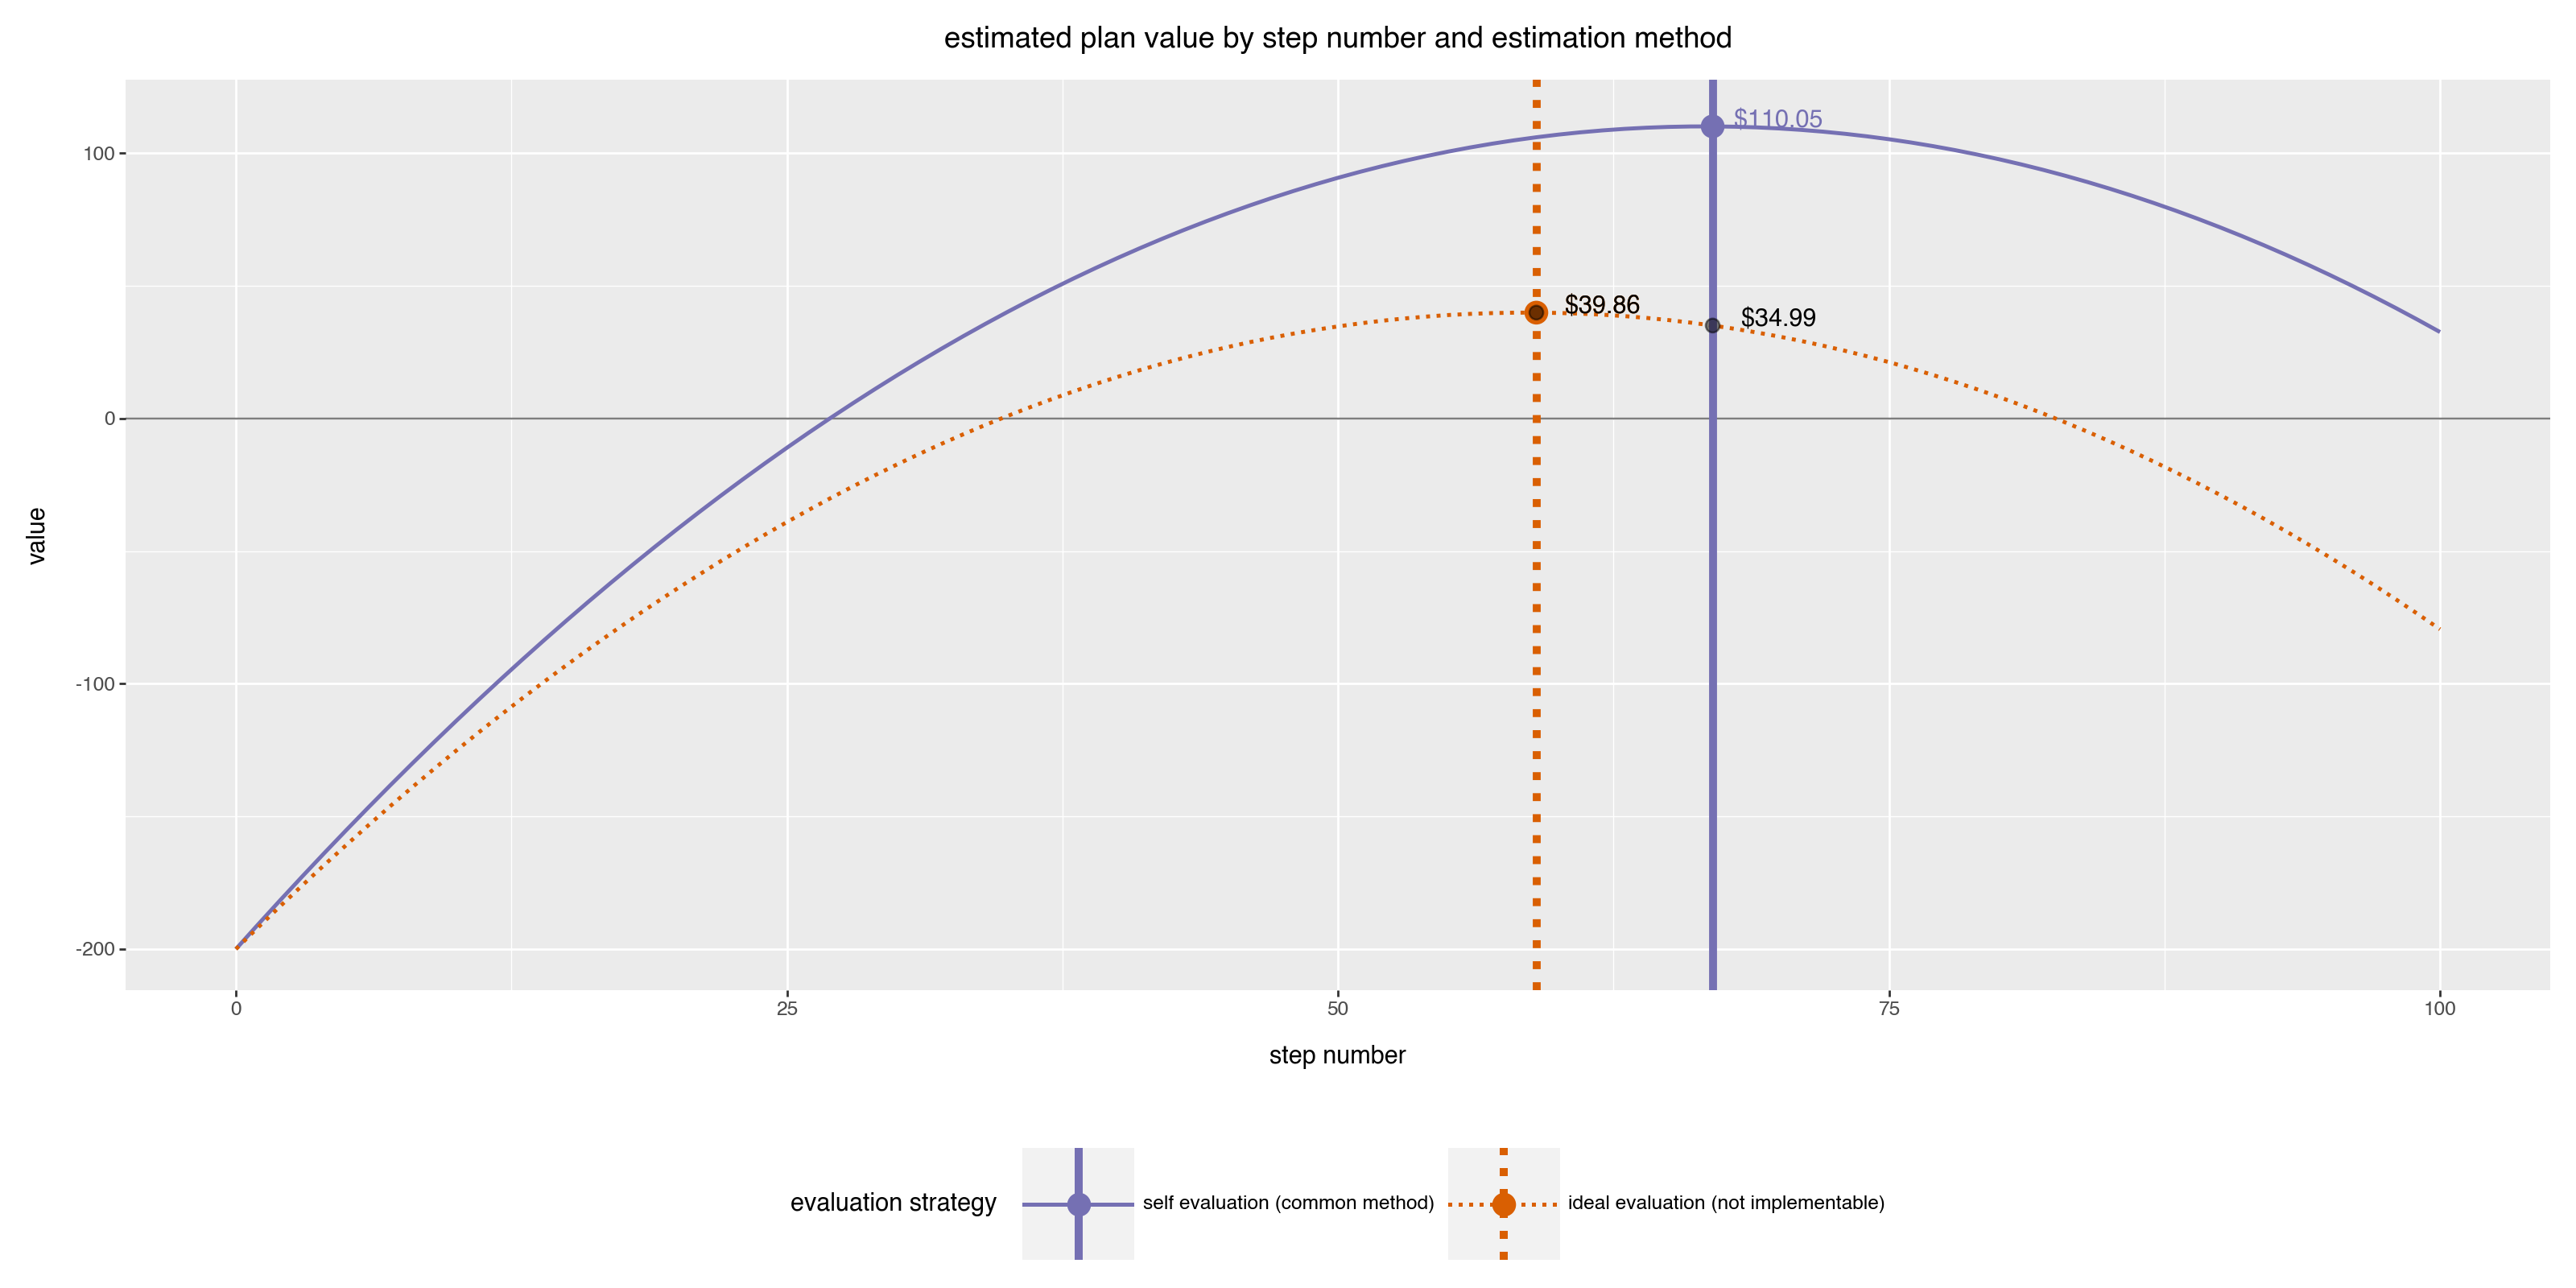

In [9]:
p2, d_summary_2 = plot_k(
    d, title="estimated plan value by step number and estimation method"
)

display(p2)

In [10]:
d_summary_2.round(2)

,step number,stopping strategy,self reported value,actual value
0,67,self evaluation (common method),110.05,34.99
1,59,ideal evaluation (not implementable),39.86,39.86


The true value of each plan is given where the vertical line crosses the orange dotted curve. So the plan picked by our optimizer is worth about `$34.99`, not `$110.05`. We also see the true optimal plan (picked where the orange dotted curve is maximal) it itself worth `$39.86`. So our our original plan is in fact pretty good, we just grossly misreported its value. However, this sort of overestimate can lose trust and scuttle an entire project.

For real data we never have the ability to calculate the ideal or orange curve. So the problem goes unnoticed until *after* the price plan goes to market. And at that point all we know is something is wrong, not what and not to what extent.

## The solution

Now that we see the problem, let's solve it. A principle in machine learning is to evaluate model quality on hold-out data. This is because the data used in training the model (which is itself an optimization process) becomes entangled with the picked model and is thus uniquely unqualified to evaluate the final model's quality. The same principle works for our objective optimization problem.

Let's try an out of sample early stopping strategy to improve our approximate optimum choice and to greatly improve the reported value of the plan. This strategy is commonly used in deep learning and in boosting. We assume we have another approximation of the objective function, $\tilde{v}_2$.

In [11]:
v_approx_2 = estimate_v(rng)

Note the above is not meant to represent fuzzing (though that also should be effective!). It is meant to represent the errors in building another attempted inference of the unknown $v_{true}$.

Now evaluate the plan steps suggested by $\tilde{v}$, using $\tilde{v}_2$.  We are only going to use $\tilde{v}_2$ to report "out of optimization value" (similar to "out of sample value") and to pick a stopping time.


In [12]:
d["hold out evaluation (implementable)"] = [f(x, v=v_approx_2) for x in d["x"]]

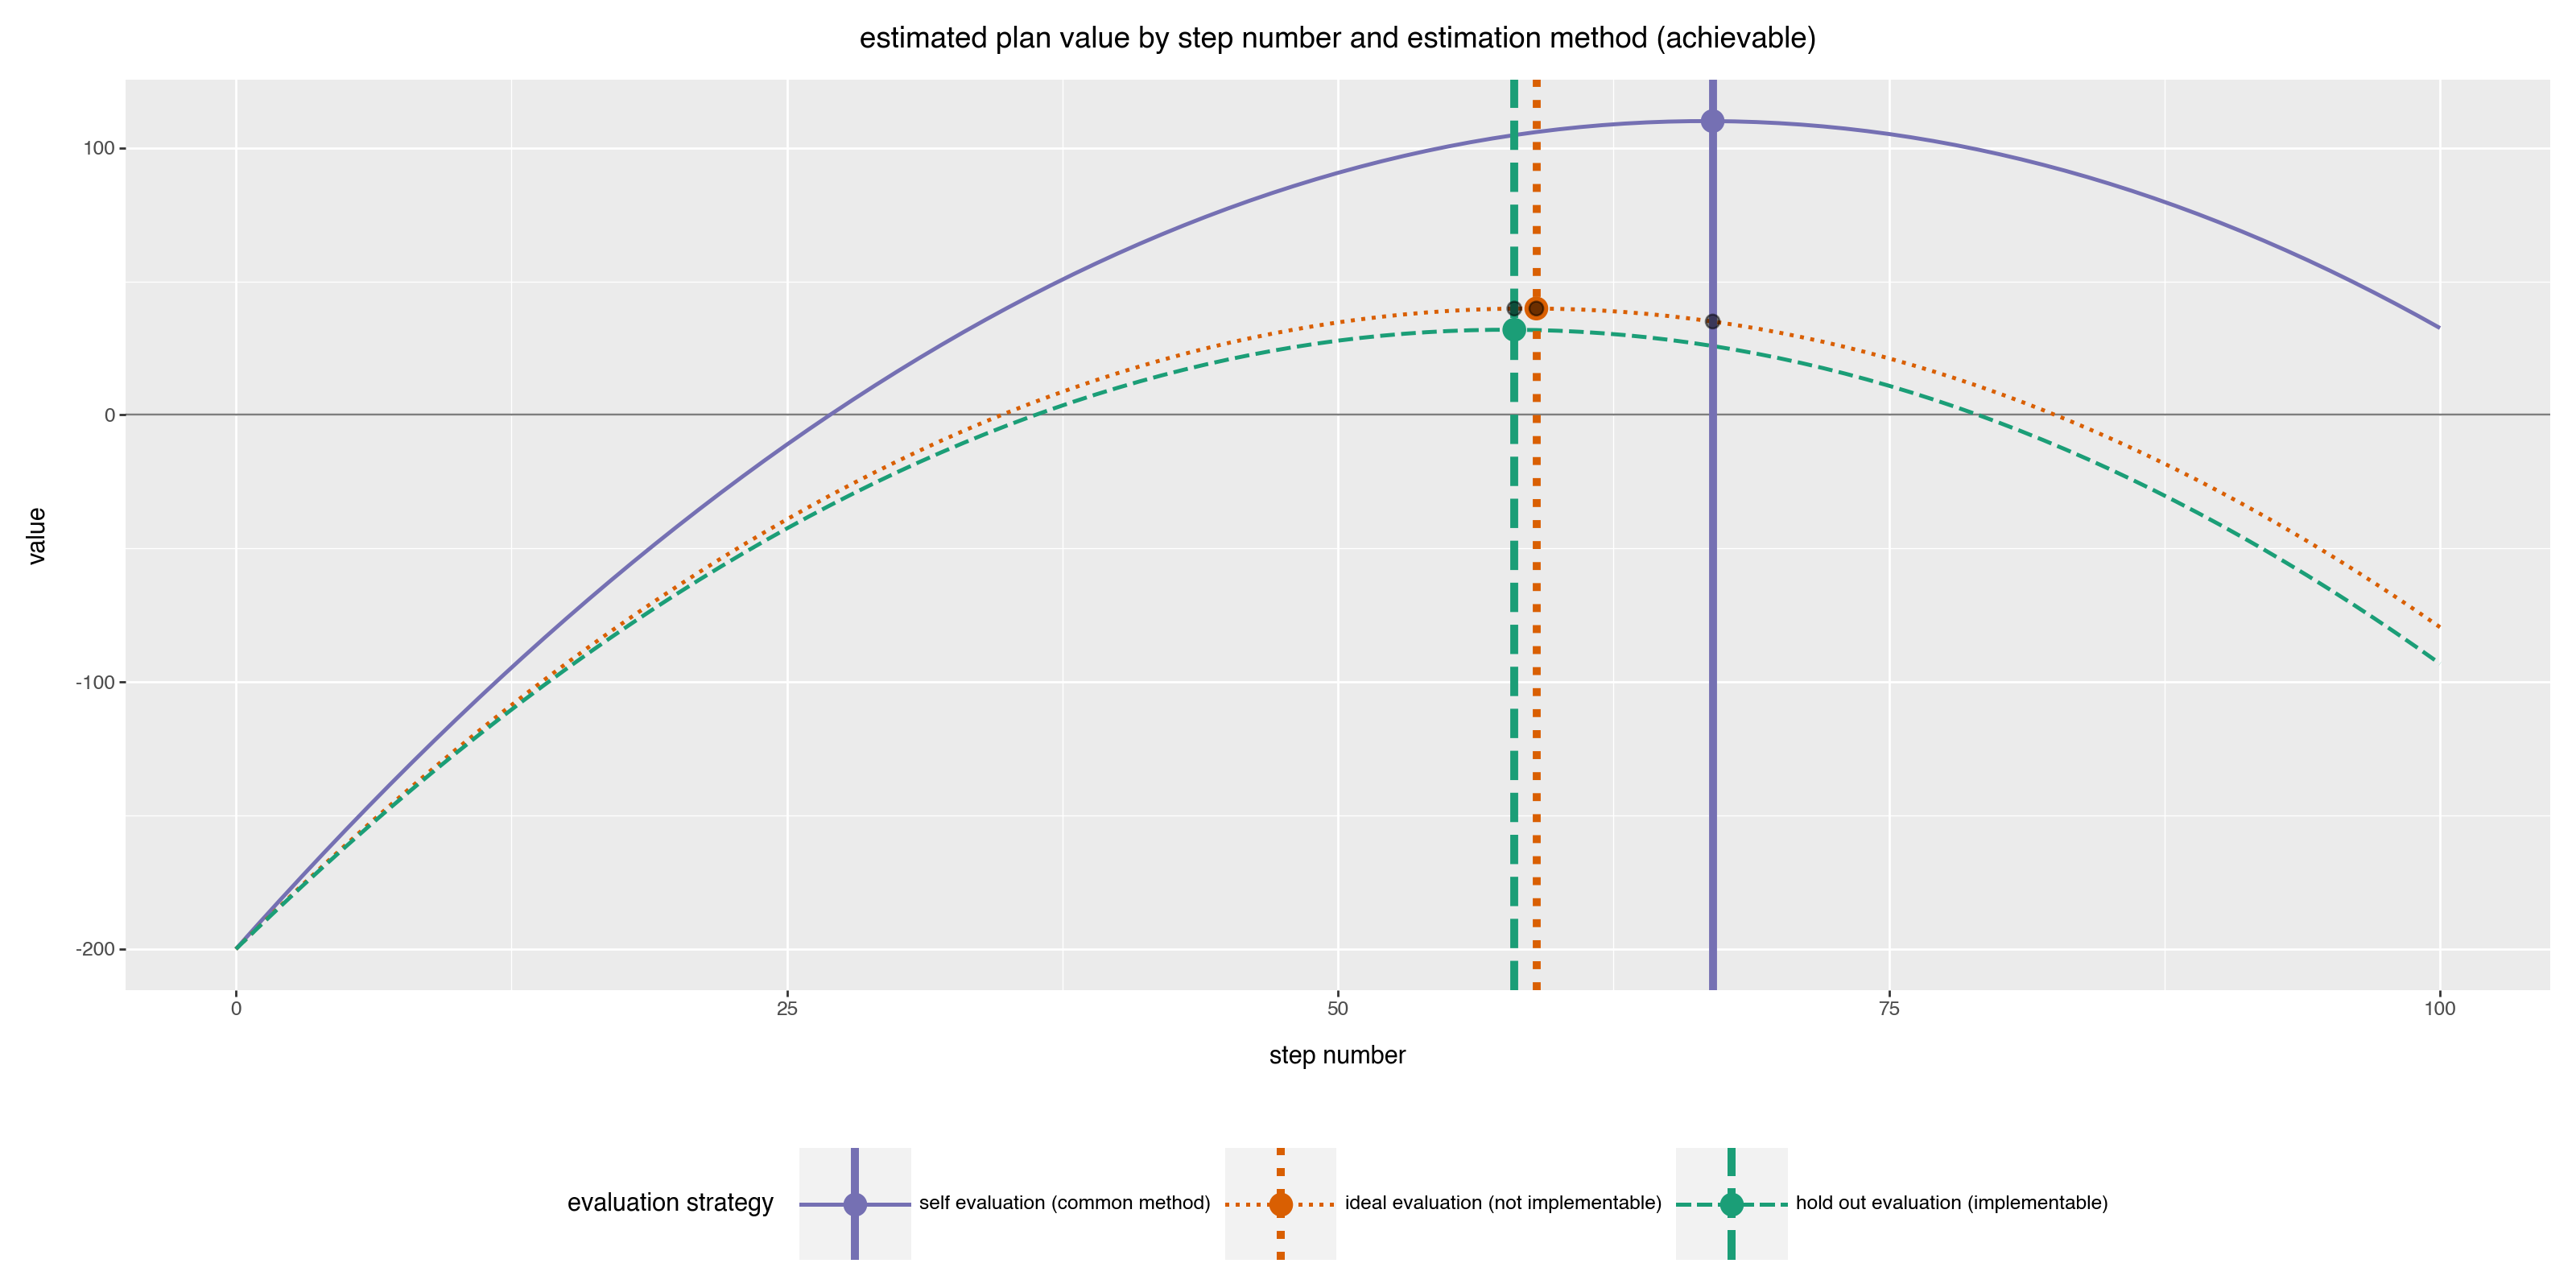

In [13]:
p3, d_summary_3 = plot_k(
    d,
    title="estimated plan value by step number and estimation method (achievable)",
    ideal_values=False,
    observed_values=False,
)

display(p3)

This table represents the true value of each of the stopping and evaluation strategies.

In [14]:
d_summary_3.round(2)

,step number,stopping strategy,self reported value,actual value
0,67,self evaluation (common method),110.05,34.99
1,59,ideal evaluation (not implementable),39.86,39.86
2,58,hold out evaluation (implementable),31.91,39.84


The green "hold out evaluation" curve is implementable and is often close the unknown orange "ideal evaluation" curve. The early stopping even improves the actual value to `$39.84`, very close to the best possible `$39.86`.

The analogy to machine learning is strong. The curves start together, and as the optimizer works, the curves pull apart. Fortunately, the "held out curve" tends to stay closer to the (unknown) true evaluation curve than the common self evaluation curve.

We can use the hold out evaluation curve to both early stop the optimizer (which in this case slightly improved the estimate) and to report a more plausible optimal value.

This exact same plan taken to market is now correctly evaluated as a success. And we have identified an even better plan in the early stop.


### Ensuring useful variation

The additional estimates of the objective function must be in some sort of useful distribution thought to surround the unknown true distribution. There are several ways to help ensure this.

  1) Use of a well calibrated probability model in a sampler such as Stan.
  2) Use of disjoint data for each project step.
  3) Use of simulated disjoint data such as with cross-methods.
  4) Use of re-sampled data for each objective inference.

An important point to take away from this discussion is that even *if* an estimate of the objective function starts unbiased, it becomes biased as we use it.

## Discussion/conclusion

In optimization projects over-use leads to deadly overestimates. The solution is to use different estimates for different stages of the project. This could even be extended to changing the estimated objective many times during optimization to improve results.

## Appendix: Sources of More Methods

The over-use issue discussed here is similar to "over-fit" as seen in statistics and machine learning. This lets us recruit methods from statistics and machine learning to help address the over-use/overestimate issue. In this note we concentrated on using different estimates for different stages. This could be extended to using disjoint data in these estimates or even trying many of the known methods for dealing with over-fit. 

A few well known methods for mitigating over-fit include:

  * [Cross methods](https://win-vector.com/2020/03/10/cross-methods-are-a-leak-variance-trade-off/)
  * Bonferroni correction
  * Regularization
  * Large margin
  * Ensemble methods
  * Aggregation/bagging
  * Maximum entropy
  * PAC methods

Many of these have analogues that can be used in optimization projects.